In [1]:
import numpy as np
import pandas as pd

import os
import pickle
import glob
import matplotlib.pyplot as plt
import time
import keras
import tensorflow as tf

import imageio
from scipy import signal
from keras.models import load_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import explained_variance_score
from sklearn.metrics import roc_curve, auc
from skimage.transform import resize
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
'''import tensorflow as tf
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:    
    print("You have a GPU enabled.")
else:    
    print("Enable a GPU before running this notebook.")'''

'import tensorflow as tf\nprint("You are using TensorFlow version", tf.__version__)\nif len(tf.config.list_physical_devices(\'GPU\')) > 0:    \n    print("You have a GPU enabled.")\nelse:    \n    print("Enable a GPU before running this notebook.")'

In [3]:
save_figures = False
file_ending = '.png'
model_string = 'NMDA'

dataset_folder = '../data'

models_folder     = os.path.join(dataset_folder, 'Models')
morphology_folder = os.path.join(dataset_folder, 'Morphology')
test_data_folder  = os.path.join(dataset_folder, 'Data_test')
#auxiliary_folder  = os.path.join(dataset_folder, 'Auxiliary')

model_filename           = os.path.join(models_folder, 'NMDA_TCN__DWT_7_128_153__model.h5')
model_metadata_filename  = os.path.join(models_folder, 'NMDA_TCN__DWT_7_128_153__training.pickle')
morphology_filename      = os.path.join(morphology_folder, 'morphology_dict.pickle')
#NN_illustration_filename = os.path.join(auxiliary_folder, 'TCN_7_layers.png')
test_files               = sorted(glob.glob(os.path.join(test_data_folder, '*_128_simulationRuns*_6_secDuration_*')))

print('-----------------------------------------------')
print('finding files: morphology and test data')
print('-----------------------------------------------')
#print('model found          : "%s"' %(model_filename.split('/')[-1]))
print('model metadata found : "%s"' %(model_metadata_filename.split('/')[-1]))
print('morphology found     : "%s"' %(morphology_filename.split('/')[-1]))
print('number of test files is %d' %(len(test_files)))
print('-----------------------------------------------')

-----------------------------------------------
finding files: morphology and test data
-----------------------------------------------
model metadata found : "NMDA_TCN__DWT_7_128_153__training.pickle"
morphology found     : "morphology_dict.pickle"
number of test files is 12
-----------------------------------------------


In [4]:
testing_3 = test_files[1]
experiment_dict = pickle.load(open(testing_3, "rb" ), encoding='latin1')


In [5]:
experiment_dict.keys()
df = pd.DataFrame(experiment_dict)
df

,Params,Results
useActiveDendrites,True,NaN
randomSeed,100511,NaN
collectAndSaveDVTs,True,NaN
numOutputSpikesPerSim,"[5, 7, 0, 0, 0, 12, 0, 0, 0, 2, 31, 8, 6, 19, ...",NaN
averageOutputFrequency,0.776042,NaN
numSimulations,128,NaN
totalSimDurationInSec,6,NaN
num_bas_ex_spikes_per_100ms_range,"[0, 750]",NaN
totalNumSimulationSeconds,768,NaN
allSegmentsLength,"[24.200878230108255, 15.18219623504249, 21.664...",NaN


In [6]:
opening_files = test_files[0]

In [7]:
def large_dataframe(file):
    experiment_dict = pickle.load(open(file, "rb"), encoding='latin1')
    df = pd.DataFrame(experiment_dict)
    df.drop('Results', inplace=True, axis=1)
    df = df.loc[['allSegmentsType', 'allSegmentsLength', 'allSegments_SectionInd', 'allSegments_DistFromSoma', 'allSegments_SectionDistFromSoma']]
    df = df.T.apply(pd.Series.explode).reset_index()
    df.drop('index', inplace=True, axis=1)
    return df

def small_dataframe(file):
    experiment_dict = pickle.load(open(file, "rb"), encoding='latin1')
    df = pd.DataFrame(experiment_dict)
    df.drop('Results', inplace=True, axis=1)
    df = df.loc[['allSectionsType', 'allSectionsLength', 'allSections_DistFromSoma']]
    df = df.T.apply(pd.Series.explode).reset_index()
    df.drop('index', inplace=True, axis=1)
    return df

def whole_dataframe(file):
    experiment_dict = pickle.load(open(file, "rb"), encoding='latin1')
    df = pd.DataFrame(experiment_dict)
    df.drop('Results', inplace=True, axis=1)
    df = df.loc[['allSectionsType', 'allSectionsLength', 'allSections_DistFromSoma', 'allSegmentsType', 'allSegmentsLength', 'allSegments_SectionInd', 'allSegments_DistFromSoma', 'allSegments_SectionDistFromSoma']]
    df = df.T.apply(pd.Series.explode)

    return df
#df_sub = df.loc[['allSectionsType', 'allSectionsLength', 'allSections_DistFromSoma']]

#df_sub.T.apply(pd.Series.explode).reset_index()
# stratify on column for basal/apical - use labelencoder

In [8]:
def multi_df(files, opener):
    lst_df = []
    for file in files:
        lst_df.append(opener(file))
        
    return pd.concat(lst_df)



In [9]:
'''testing = test_files[:3]
dfs = multi_df(testing)''' #testing the definitions

'testing = test_files[:3]\ndfs = multi_df(testing)'

In [10]:
#whole_df = multi_df(test_files, whole_dataframe)

In [11]:
dfs = multi_df(test_files, large_dataframe)

In [51]:
dfs

,allSegmentsType,allSegmentsLength,allSegments_DistFromSoma,idx
0,basal,24.2009,23.6851,0
1,basal,15.1822,43.3767,1
2,basal,21.6644,61.8,2
3,basal,21.6644,83.4644,2
4,basal,21.6644,105.129,2
...,...,...,...,...
634,apical,18.7358,146.64,189
635,apical,18.7358,165.375,189
636,apical,22.0852,92.1071,190
637,apical,36.0978,121.199,191


In [12]:
df_193 = multi_df(test_files, small_dataframe)

In [32]:
#dfs['idx'] = dfs['allSegments_SectionInd']
#dfs.drop('allSegments_SectionDistFromSoma', inplace = True, axis=1)
#dfs.drop('allSegments_SectionInd', inplace = True, axis=1)
#dfs.rename(columns={'index':'idx'}, inplace=True)
#df_193.rename(columns={'index':'idx'}, inplace=True)

#df_193['idx'] = df_193.index
#dfs = iterates through 639 items - Segments - I have a column that shows the idx of df_193
#df_193 = iterates through 193 items - Sections
df_193.drop('allSectionsLength', inplace = True, axis=1)

In [71]:
def test(x):
    for index, row in dfs.iteritems():
        if index in df_193.iterrows():
            dfs[k].append(df_193[row])
            print(dfs)
    return df

dfs['idx']=dfs['idx'].astype(float).astype(int)

df_m = dfs.merge(df_193.drop_duplicates(), how= 'inner', left_on=['idx'],right_on =['idx'])
#test10 = dfs.join(df_193.set_index('idx'), on='idx')
#test10 = pd.merge_ordered(dfs, df_193, fill_method="ffill", left_by="idx")


In [73]:
df_m.drop('idx', inplace = True, axis=1)

In [85]:
df_m.drop('allSectionsType', inplace = True, axis=1)

In [86]:
le = LabelEncoder()
df_m['allSegmentsType'] = le.fit_transform(df_m['allSegmentsType'])
#1 = Basal
#0 = apical
df_x = df_m.copy(deep=True)

In [87]:
y = np.array(pd.Series(dfs['allSegmentsType']))
y

array([1, 1, 1, ..., 0, 0, 0])

In [104]:
df_x.drop('allSegmentsType', inplace = True, axis=1)

In [105]:
X = df_x


In [106]:
X

,allSegmentsLength,allSegments_DistFromSoma,allSections_DistFromSoma
0,24.2009,23.6851,11.5847
1,24.2009,23.6851,11.5847
2,24.2009,23.6851,11.5847
3,24.2009,23.6851,11.5847
4,24.2009,23.6851,11.5847
...,...,...,...
7663,30.0747,118.187,103.15
7664,30.0747,118.187,103.15
7665,30.0747,118.187,103.15
7666,30.0747,118.187,103.15


In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33)

In [108]:
lr = LogisticRegression()
model = lr.fit(X_train, y_train)

In [109]:
model.classes_

array([0, 1])

In [110]:
model.intercept_

array([-0.61435584])

In [111]:
model.coef_

array([[ 0.0066905 ,  0.00154127, -0.0014603 ]])

In [112]:
model.predict_proba(X_train)

array([[0.61254926, 0.38745074],
       [0.593638  , 0.406362  ],
       [0.52725978, 0.47274022],
       ...,
       [0.60480971, 0.39519029],
       [0.60098654, 0.39901346],
       [0.55824216, 0.44175784]])

In [113]:
model.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

In [114]:
model.score(X_train, y_train)

0.5900330932450847

In [115]:
model.score(X_test, y_test)

0.5898854207822994

In [116]:
confusion_matrix(y_test, model.predict(X_test))

array([[1493,    0],
       [1038,    0]])

In [117]:
confusion_matrix(y_train, model.predict(X_train))

array([[3031,    0],
       [2106,    0]])

-True negatives in the upper-left position

-False negatives in the lower-left position

-False positives in the upper-right position

-True positives in the lower-right position

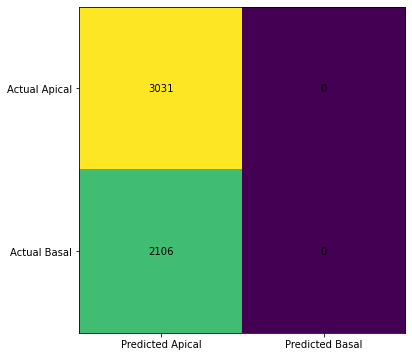

In [118]:
cm = confusion_matrix(y_train, model.predict(X_train))

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Apical', 'Predicted Basal'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Apical', 'Actual Basal'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.show()


In [119]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74      3031
           1       0.00      0.00      0.00      2106

    accuracy                           0.59      5137
   macro avg       0.30      0.50      0.37      5137
weighted avg       0.35      0.59      0.44      5137



/home/pteradox/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [120]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1493
           1       0.00      0.00      0.00      1038

    accuracy                           0.59      2531
   macro avg       0.29      0.50      0.37      2531
weighted avg       0.35      0.59      0.44      2531



/home/pteradox/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
